In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

path1 = '/Users/mouyasushi/Desktop/vici holdings/Test/data/train_data.npy'
train_data = np.load(path1)

path2 = '/Users/mouyasushi/Desktop/vici holdings/Test/data/train_labels.npy'
train_labels = np.load(path2)

# 轉換為 DataFrame
df = pd.DataFrame(train_data)
df['label'] = train_labels  # 添加標籤列


In [2]:
def check_missing_values(df):
   
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    missing_data = pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    })
    
    missing_data = missing_data[missing_data['missing_percent'] > 0].sort_values('missing_percent', ascending=False)
    
    if len(missing_data) > 0:
        print("missing values:")
        print(missing_data)
    else:
        print("no missing values")
    
    return missing_data

def detect_constant_features(df):
    constant_features = []
    
    for col in df.columns:
        if df[col].nunique() == 1:
            constant_features.append(col)

    
    return constant_features

def detect_binary_features(df):
    binary_features = []
    
    for col in df.columns:
    
        if df[col].dtype != 'object':
            unique_values = df[col].unique()
            if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
                binary_features.append(col)
    
    return binary_features


In [3]:
missing_data = check_missing_values(df)
missing_data

no missing values


,missing_count,missing_percent


In [4]:
constant_feature = detect_constant_features(df)
constant_feature

[]

In [5]:
binary_feature = detect_binary_features(df)
binary_feature

[56, 57, 58, 59, 60]

In [6]:
def analyze_skewness(df, threshold=1.0):
    """
    分析数据偏度
    """
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    skew_values = df[numeric_cols].skew()
    
    highly_skewed = skew_values[abs(skew_values) > threshold].sort_values(ascending=False)
    
    return highly_skewed



In [7]:
skewed_features = analyze_skewness(df)
skewed_features.head()

52    465.216052
67     85.777991
65     60.587154
61     60.378028
62     60.289686
dtype: float64

In [8]:
def analyze_kurtosis(df, threshold=3.0):
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    kurt_values = df[numeric_cols].kurtosis()
    
    high_kurtosis = kurt_values[kurt_values > threshold].sort_values(ascending=False)
    
    if len(high_kurtosis) > 0:
        print(f"high kurtosis feature (kurtosis > {threshold}):")
        print(high_kurtosis)
    else:
        print(f"no high kurtosis feature (kurtosis > {threshold})")
    
    return high_kurtosis


In [9]:
kurt_features = analyze_kurtosis(df)



high kurtosis feature (kurtosis > 3.0):
52    341159.105444
67      8739.241466
65      4363.527474
62      4303.511064
61      4300.096712
64      4237.464057
63      3839.787366
66       451.778121
55       349.670870
49       229.815216
69        53.654486
4         43.335396
2         42.065093
5         41.680203
3         35.947979
17        22.461061
15        21.065172
68        20.851945
53        12.811908
54         9.201924
40         8.777380
14         8.200595
16         7.954253
57         4.593446
56         4.245312
42         3.792548
44         3.289681
13         3.158244
dtype: float64


In [10]:
def detect_outliers_zscore(df, threshold=3.0):
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    outlier_counts = {}
    
    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outliers = (z_scores > threshold).sum()
        if outliers > 0:
            outlier_counts[col] = outliers
    
    # 排序并显示结果
    if outlier_counts:
        outlier_df = pd.DataFrame({
            'outlier_count': outlier_counts,
            'percentage(%)': {k: (v/len(df))*100 for k, v in outlier_counts.items()}
        }).sort_values('outlier_count', ascending=False)
        print("(|Z| > {}):".format(threshold))
        print(outlier_df)
    else:
        print(f"no outliers detected (|Z| > {threshold})")
    
    



In [11]:
outliers_zscore = detect_outliers_zscore(df)
outliers_zscore

(|Z| > 3.0):
    outlier_count  percentage(%)
16          53580       4.562093
15          52145       4.439909
17          48889       4.162675
14          42395       3.609741
53          41529       3.536005
..            ...            ...
61           1242       0.105751
64           1242       0.105751
62           1242       0.105751
0             788       0.067095
24            128       0.010899

[65 rows x 2 columns]


In [12]:
def detect_outliers_iqr(df):
   
    numeric_cols = df.select_dtypes(include=np.number).columns
    outlier_counts = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers > 0:
            outlier_counts[col] = outliers
    
    if outlier_counts:
        outlier_df = pd.DataFrame({
            'outlier_count': outlier_counts,
            'percentage(%)': {k: (v/len(df))*100 for k, v in outlier_counts.items()}
        }).sort_values('outlier_count', ascending=False)
        print("stats of outliers detected by IQR:")
        print(outlier_df)
    else:
        print("no outliers detected by IQR")
    
    

def plot_feature_distribution(df, feature, figsize=(12, 5)):
    
    plt.figure(figsize=figsize)
    
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} distribution')
    plt.xlabel(feature)
    plt.ylabel('frequency')
    
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[feature])
    plt.title(f'{feature} boxplot')
    plt.tight_layout()
    plt.show()
    
    
    print(f"\n{feature} statistics:")
    desc = df[feature].describe()
    print(desc)
    print(f"skewness: {df[feature].skew():.4f}")
    print(f"kurtosis: {df[feature].kurtosis():.4f}")



In [13]:
outliers_iqr = detect_outliers_iqr(df)
outliers_iqr

stats of outliers detected by IQR:
    outlier_count  percentage(%)
1          509259      43.361082
12         509259      43.361082
13         457287      38.935903
61         226636      19.297022
14         172716      14.705980
..            ...            ...
26           2176       0.185276
29           1967       0.167481
27           1063       0.090510
0             287       0.024437
24              8       0.000681

[67 rows x 2 columns]


Plot feature distributions 

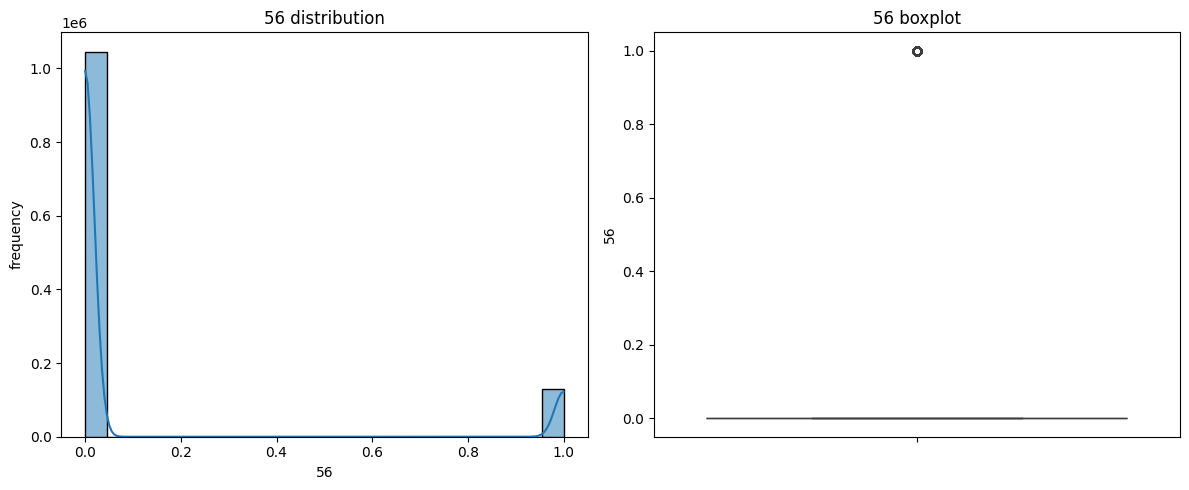


56 statistics:
count    1.174461e+06
mean     1.096231e-01
std      3.124195e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: 56, dtype: float64
skewness: 2.4991
kurtosis: 4.2453


In [14]:
plot_feature_distribution(df, 56)

In [15]:
def feature_transformation(df, features_to_transform, method='log'):
    """
    特征变换函数
    
    参数:
    df - 输入的数据框
    features_to_transform - 需要变换的特征列表
    method - 默认变换方法 ('log', 'sqrt', 'boxcox', 'yeo-johnson')
    
    返回:
    df_transformed - 包含原始特征和变换后特征的数据框
    """
    df_transformed = df.copy()
    
    for feature in features_to_transform:  # only transform the features in the list
        # 检查特征是否存在
        if feature not in df.columns:
            print(f" {feature} not exist, skip")
            continue
        
        # 检查是否为数值类型
        if not np.issubdtype(df[feature].dtype, np.number):
            print(f" {feature} is not numeric, skip")
            continue
            
        
        current_method = method
        
        # 检查数据范围并确定适合的变换方法
        if current_method == 'log':
            if (df[feature] <= 0).any():
                print(f" {feature} has 0 or negative value, not suitable for log transformation")
                if (df[feature] < 0).any():
                    print(f" {feature} has negative values, using yeo-johnson instead")
                    current_method = 'yeo-johnson'
                else:  # 只有0值但没有负值
                    print(f" {feature} has zero values, using boxcox with offset instead")
                    current_method = 'boxcox'
        
        # 根据确定的变换方法应用变换
        try:
            if current_method == 'log':
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"applied log transformation to {feature}")
                
            elif current_method == 'sqrt':
                # 检查是否有负值
                if (df[feature] < 0).any():
                    print(f" {feature} has negative values, not suitable for sqrt transformation")
                    print(f" using yeo-johnson instead")
                    current_method = 'yeo-johnson'
                    df_transformed[f"{feature}_yeojohnson"], _ = stats.yeojohnson(df[feature])
                    print(f"applied yeo-johnson transformation to {feature}")
                else:
                    df_transformed[f"{feature}_sqrt"] = np.sqrt(df[feature])
                    print(f"applied square root transformation to {feature}")
                
            elif current_method == 'boxcox':
                # Box-Cox变换 - 只适用于严格正值
                if (df[feature] <= 0).any():
                    # 如果有非正值，进行偏移
                    min_val = df[feature].min()
                    shift = abs(min_val) + 1
                    shifted_values = df[feature] + shift
                    df_transformed[f"{feature}_boxcox"], lambda_val = stats.boxcox(shifted_values)
                    print(f"applied boxcox transformation to {feature} (with +{shift} offset)")
                else:
                    df_transformed[f"{feature}_boxcox"], lambda_val = stats.boxcox(df[feature])
                    print(f"applied boxcox transformation to {feature} (lambda={lambda_val:.4f})")
                    
            elif current_method == 'yeo-johnson':
                # Yeo-Johnson变换 - 可以处理负值
                df_transformed[f"{feature}_yeojohnson"], lambda_val = stats.yeojohnson(df[feature])
                print(f"applied yeo-johnson transformation to {feature} (lambda={lambda_val:.4f})")
                
            else:
                print(f"Unknown transformation method '{current_method}' for {feature}, skip")
                
        except Exception as e:
            print(f"Error applying {current_method} transformation to {feature}: {str(e)}")
    
    return df_transformed

In [16]:

skewed_features = [52, 67, 65, 61, 62, 64, 63, 66, 69, 5, 49, 3, 68, 53, 57, 56, 54, 55, 51, 15, 31, 34, 41, 43, 39, 16, 14, 44, 42, 40, 4, 2]
binary_feature = [56, 57, 58, 59, 60]

to_be_transformed = list(set(skewed_features) - set(binary_feature))



In [17]:
df_transformed = feature_transformation(df, to_be_transformed, method='yeo-johnson') # 包含正偏以及負偏

applied yeo-johnson transformation to 2 (lambda=1.3159)
applied yeo-johnson transformation to 3 (lambda=0.5655)
applied yeo-johnson transformation to 4 (lambda=1.2665)
applied yeo-johnson transformation to 5 (lambda=0.5671)
applied yeo-johnson transformation to 14 (lambda=1.3565)
applied yeo-johnson transformation to 15 (lambda=1.1062)
applied yeo-johnson transformation to 16 (lambda=1.3350)
applied yeo-johnson transformation to 31 (lambda=1.6273)
applied yeo-johnson transformation to 34 (lambda=1.7628)
applied yeo-johnson transformation to 39 (lambda=2.1355)
applied yeo-johnson transformation to 40 (lambda=2.8369)
applied yeo-johnson transformation to 41 (lambda=2.0686)
applied yeo-johnson transformation to 42 (lambda=2.2423)
applied yeo-johnson transformation to 43 (lambda=2.0269)
applied yeo-johnson transformation to 44 (lambda=2.1412)
applied yeo-johnson transformation to 49 (lambda=0.7191)
applied yeo-johnson transformation to 51 (lambda=0.3627)
applied yeo-johnson transformation 

Standardize 
- 先 tranform 再 standardize 效果會比較好
- 使用 standard scaler 

In [18]:
from sklearn.preprocessing import StandardScaler

def standardize_features(df, features_to_standardize, return_scaler=False):
    """
    使用StandardScaler对指定特征进行标准化，可选择返回标准化器
    
    参数:
    df - 输入的数据框
    features_to_standardize - 需要标准化的特征列表
    return_scaler - 是否返回训练好的标准化器（用于测试集）
    
    返回:
    df_standardized - 包含原始特征和标准化后特征的数据框
    scaler_dict - (可选) 特征到其标准化器的映射字典
    """
    
    df_standardized = df.copy()
    
    scaler_dict = {}
    
    valid_features = []
    for feature in features_to_standardize:
        if feature not in df.columns:
            continue
            
        
        if not np.issubdtype(df[feature].dtype, np.number):
            print(f" {feature} is not numeric, skip")
            continue
            
        valid_features.append(feature)
    
    if valid_features:
        
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(df[valid_features])
        
        
        for i, feature in enumerate(valid_features):
            df_standardized[f"{feature}_std"] = scaled_values[:, i]
            print(f"applied z-score normalization to {feature}")
        
        if return_scaler:
            scaler_dict = {feature: (scaler.mean_[i], scaler.scale_[i]) 
                          for i, feature in enumerate(valid_features)}
    
    if return_scaler:
        return df_standardized, scaler_dict
    else:
        return df_standardized

In [19]:
kurt_features.index


Index([52, 67, 65, 62, 61, 64, 63, 66, 55, 49, 69,  4,  2,  5,  3, 17, 15, 68,
       53, 54, 40, 14, 16, 57, 56, 42, 44, 13],
      dtype='object')

In [20]:

kurt_features = [52, 67, 65, 62, 61, 64, 63, 66, 55, 49, 69,  4,  2,  5,  3, 17, 15, 68,
       53, 54, 40, 14, 16, 57, 56, 42, 44, 13]

kurt_to_be_std = list(set(kurt_features)  - set(binary_feature))
to_be_std = to_be_transformed + kurt_to_be_std

to_be_std

[2,
 3,
 4,
 5,
 14,
 15,
 16,
 31,
 34,
 39,
 40,
 41,
 42,
 43,
 44,
 49,
 51,
 52,
 53,
 54,
 55,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 64,
 65,
 2,
 3,
 4,
 5,
 66,
 67,
 68,
 69,
 13,
 14,
 15,
 16,
 17,
 40,
 42,
 44,
 49,
 52,
 53,
 54,
 55,
 61,
 62,
 63]

In [21]:
df_standardized = standardize_features(df_transformed, to_be_std)

applied z-score normalization to 2
applied z-score normalization to 3
applied z-score normalization to 4
applied z-score normalization to 5
applied z-score normalization to 14
applied z-score normalization to 15
applied z-score normalization to 16
applied z-score normalization to 31
applied z-score normalization to 34
applied z-score normalization to 39
applied z-score normalization to 40
applied z-score normalization to 41
applied z-score normalization to 42
applied z-score normalization to 43
applied z-score normalization to 44
applied z-score normalization to 49
applied z-score normalization to 51
applied z-score normalization to 52
applied z-score normalization to 53
applied z-score normalization to 54
applied z-score normalization to 55
applied z-score normalization to 61
applied z-score normalization to 62
applied z-score normalization to 63
applied z-score normalization to 64
applied z-score normalization to 65
applied z-score normalization to 66
applied z-score normalization to

outlier 目前可慮如何處理
- 清掉可能導致訊息損失
- 厚尾分布在金融資料常見 
- 目前先保持不動

In [22]:
# def handle_outliers(df, features, method='cap', threshold=3.0):
#     """
#     处理离群值
#     """
#     df_cleaned = df.copy()
    
#     for feature in features:
#         if feature not in df.columns:
#             print(f"特征 {feature} 不存在，跳过")
#             continue
            
#         # 跳过非数值列
#         if not np.issubdtype(df[feature].dtype, np.number):
#             print(f"特征 {feature} 不是数值类型，跳过")
#             continue
            
#         if method == 'cap':
#             # 截断方法
#             Q1 = df[feature].quantile(0.25)
#             Q3 = df[feature].quantile(0.75)
#             IQR = Q3 - Q1
            
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
            
#             # 截断离群值
#             df_cleaned[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
#             print(f"对特征 {feature} 应用了IQR截断")
            
#         elif method == 'remove':
#             # 移除离群值
#             z_scores = np.abs(stats.zscore(df[feature].dropna()))
#             outlier_mask = z_scores > threshold
#             # 创建一个布尔掩码，其中True代表要保留的行
#             keep_mask = ~outlier_mask
            
#             # 应用掩码到数据框的行
#             # 注意：这会过滤掉整行数据，可能不是您想要的
#             original_shape = df_cleaned.shape
#             df_cleaned = df_cleaned[~outlier_mask]
#             print(f"从特征 {feature} 移除了 {original_shape[0] - df_cleaned.shape[0]} 行离群值")
            
#     return df_cleaned

In [23]:
# df_cleaned = handle_outliers(df_standardized, skewed_features.index, method='cap')

VIF 
- 移除共線性feature --> takes too long 

In [24]:
# # 创建新文件 fast_vif_analyzer.py，然后导入
# from fast_vif_analyzer import optimized_vif_analysis

# # 使用新的优化版本
# result = optimized_vif_analysis(
#     df=df_standardized,
#     categorical_features=['56', '57', '58', '59', '60'],
#     target_col='label',
#     vif_threshold=10.0
# )

# X_reduced = result['X_reduced']

feature important analysis 
- light GBM --> more suitable 
- MI score 

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


使用中文字体: SimHei
开始计算特征重要性...


开始训练LightGBM模型:  60%|██████    | 3/5 [00:02<00:03,  1.51s/it]            

计算特征重要性中...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.405120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31559
[LightGBM] [Info] Number of data points in the train set: 939568, number of used features: 132
[LightGBM] [Info] Start training from score -0.611953
[LightGBM] [Info] Start training from score -1.519381
[LightGBM] [Info] Start training from score -1.431870


特征重要性计算完成！: 100%|██████████| 5/5 [01:28<00:00, 17.75s/it]        
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: 

原始特征数量: 132
选中的特征数量: 22
选中特征解释了总方差的: 94.87%
生成特征重要性可视化...


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

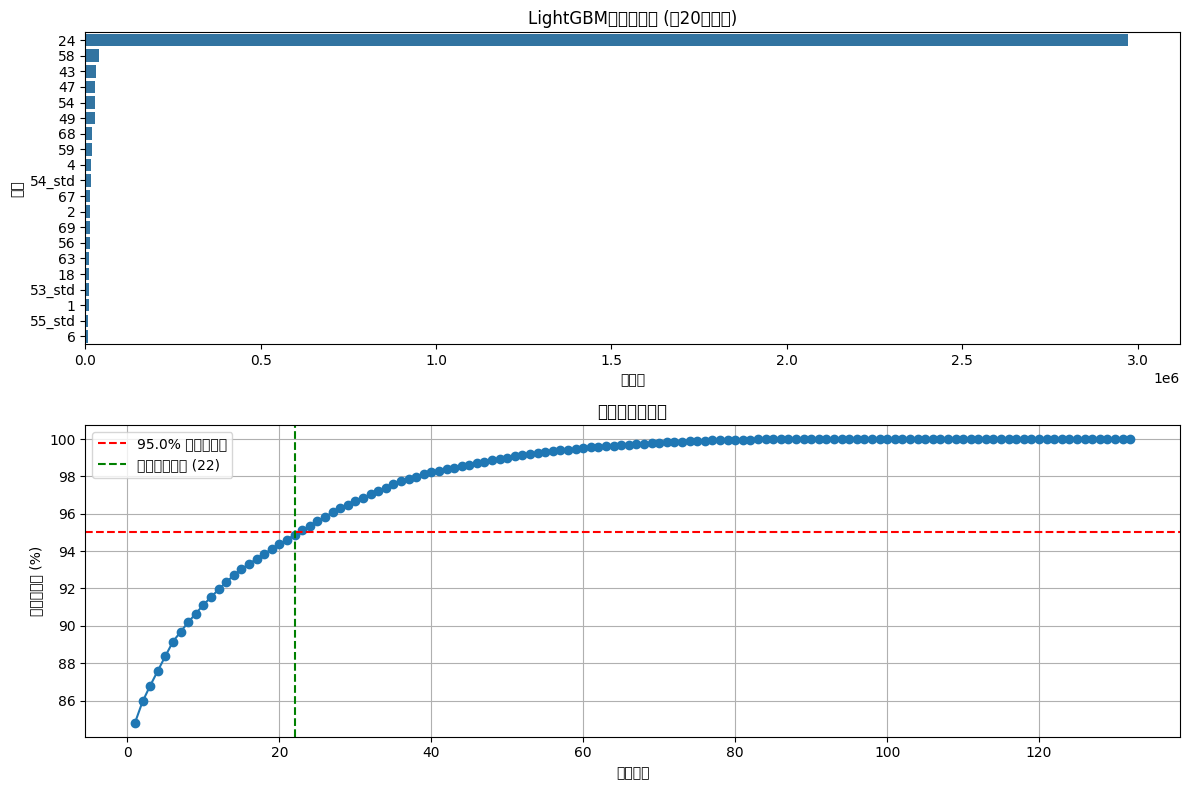

保存结果到文件...
结果保存完成！


In [25]:
from simple_feature_importance import calculate_simple_feature_importance

importance_df, selected_features = calculate_simple_feature_importance(
    df_standardized,
    target_col='label',
    categorical_features=['56', '57', '58', '59', '60'],
    threshold=0.95  
)

In [26]:
print(importance_df.head(22))
print(f'choose{len(selected_features)}features')


        特征           重要性     重要性百分比      累计重要性
0       24  2.972467e+06  84.823665  84.823665
1       58  3.966230e+04   1.131821  85.955486
2       43  2.970768e+04   0.847752  86.803238
3       47  2.789208e+04   0.795941  87.599179
4       54  2.761665e+04   0.788081  88.387260
5       49  2.702071e+04   0.771075  89.158336
6       68  1.838805e+04   0.524730  89.683065
7       59  1.789701e+04   0.510717  90.193783
8        4  1.633953e+04   0.466272  90.660055
9   54_std  1.621314e+04   0.462666  91.122720
10      67  1.464668e+04   0.417964  91.540685
11       2  1.418569e+04   0.404809  91.945494
12      69  1.386600e+04   0.395687  92.341180
13      56  1.267906e+04   0.361815  92.702996
14      63  1.159414e+04   0.330856  93.033851
15      18  9.857194e+03   0.281289  93.315141
16  53_std  9.564413e+03   0.272934  93.588075
17       1  9.338972e+03   0.266501  93.854576
18  55_std  9.055324e+03   0.258407  94.112983
19       6  8.882358e+03   0.253471  94.366454
20      14  8

NOTE: 
- 54_std 和 54重疊了
- 不刪除原因，標準化過後的feature 可能導致某些訊息丟失

Feature selection and PCA 
- 先feature selection 再 PCA 可以節省計算

In [27]:
selected_features

['24',
 '58',
 '43',
 '47',
 '54',
 '49',
 '68',
 '59',
 '4',
 '54_std',
 '67',
 '2',
 '69',
 '56',
 '63',
 '18',
 '53_std',
 '1',
 '55_std',
 '6',
 '14',
 '3']

使用中文字体: SimHei
开始PCA降维过程...


特征标准化完成，拟合PCA:  50%|█████     | 2/4 [00:00<00:00, 37.81it/s] 

警告: 以下选定特征在数据框中不存在: ['24', '58', '43', '47', '54', '49', '68', '59', '4', '67', '2', '69', '56', '63', '18', '1', '6', '14', '3']
继续使用剩余的3个特征
标准化特征...
原始维度: 3
PCA降维后的维度: 3
维度降低: 0 (0.0%)
保留的方差: 100.00%


PCA拟合完成，准备可视化和结果:  75%|███████▌  | 3/4 [00:00<00:00, 16.50it/s]findfont: Font family 'SimHei' not found.


生成PCA可视化...


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

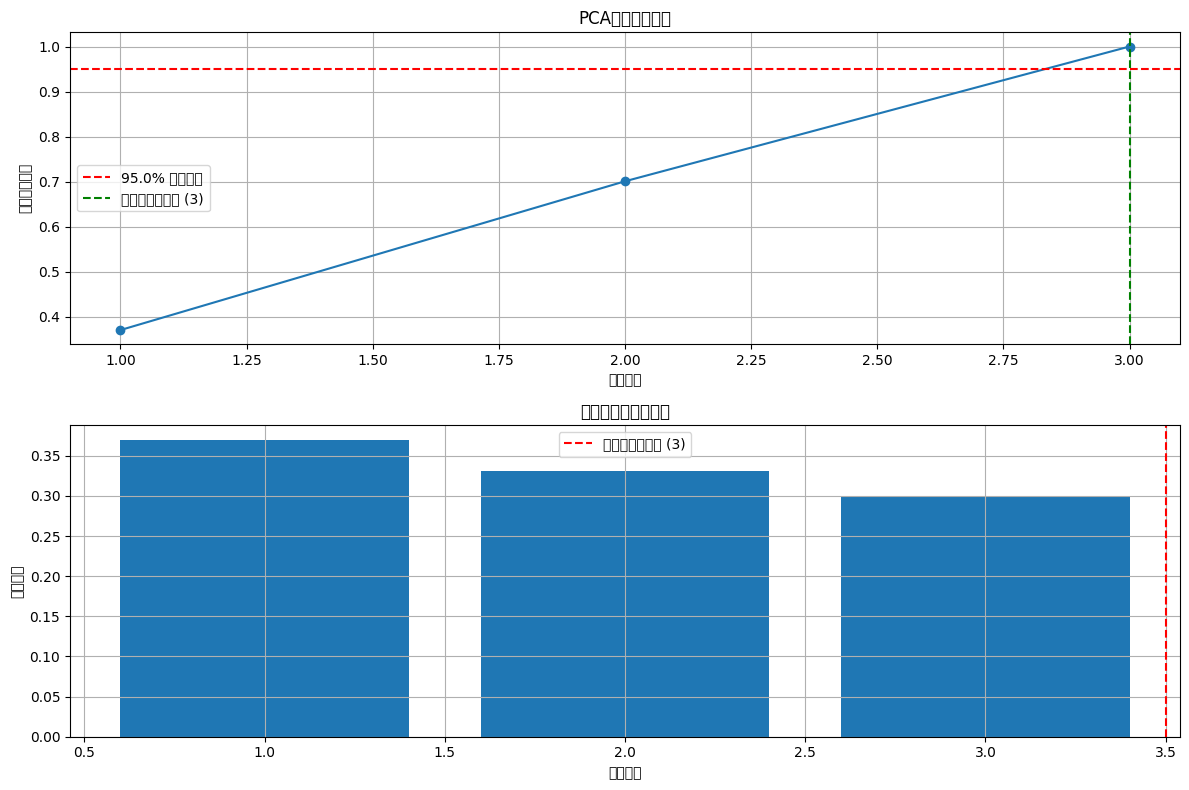

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

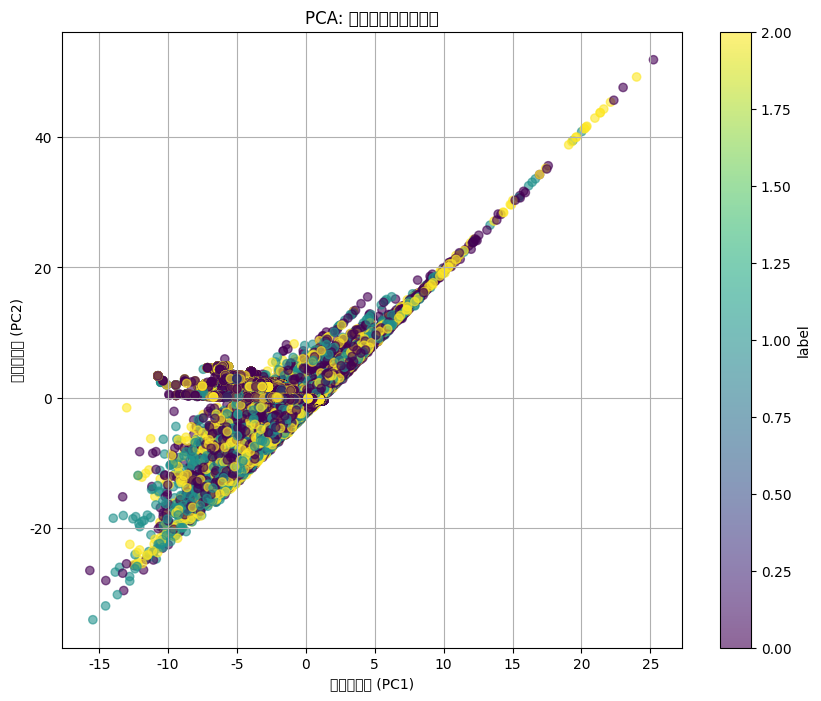

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

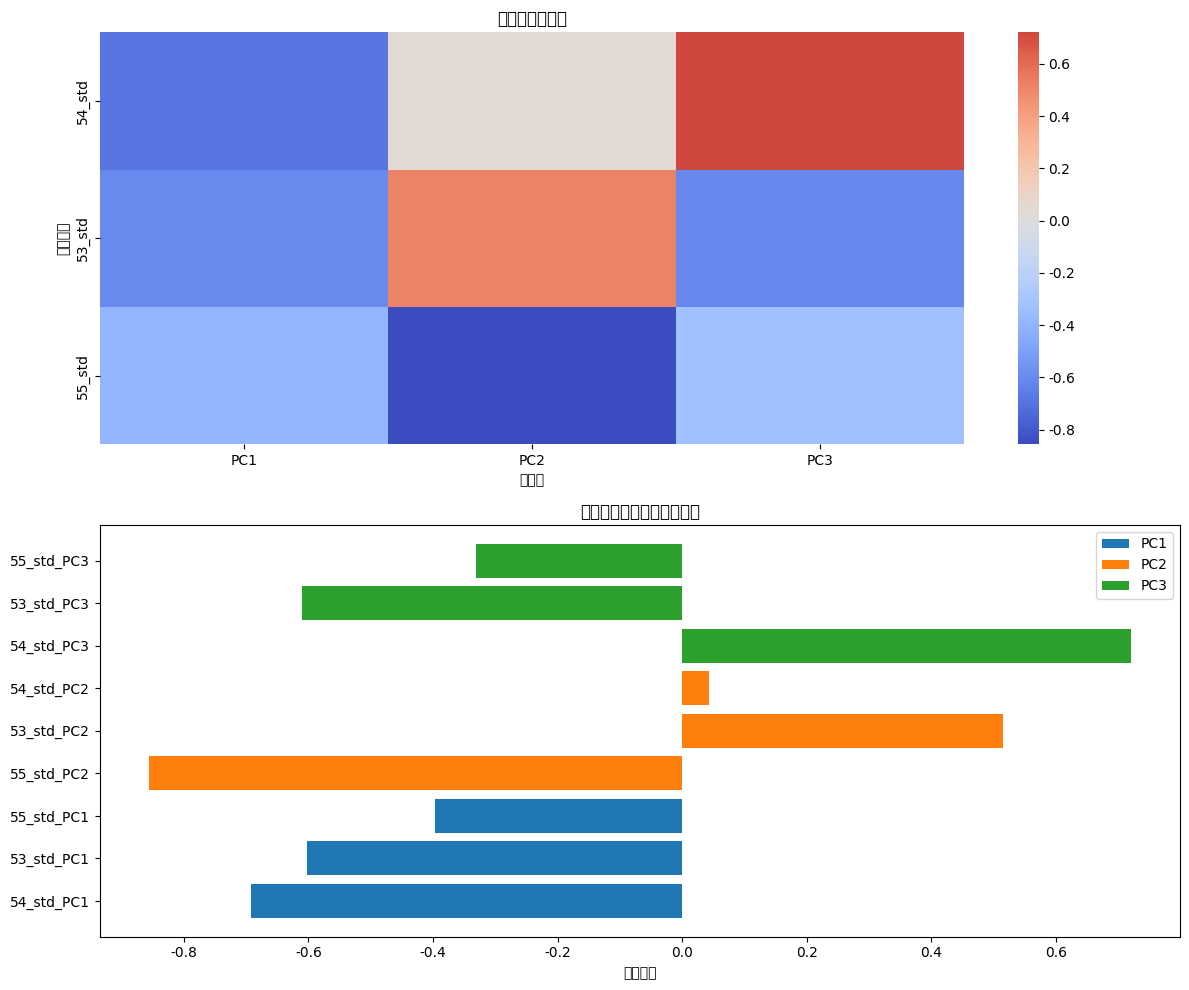

保存PCA结果...


PCA过程完成!: 100%|██████████| 4/4 [01:02<00:00, 15.73s/it]                 

PCA结果已保存!


In [28]:
from simple_pca import apply_pca_to_selected_features


pca_df, pca_model, explained_variance = apply_pca_to_selected_features(
    df_standardized,
    selected_features=selected_features,  
    target_col='label',
    variance_threshold=0.95
)